# Introduction

This is my attempt for [Kaggle's Housing Price Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), where participants have to use regression techniques in order to predict housing prices. 

In order to accomplish my goal of accurately predicting housing prices, I will perform EDA on the given training dataset. This will allow me to see trends and patterns that may prove useful when I build the prediction model down the line. 

More specifically, I will first try to understand the data overall (i.e. the number and variety of predictors, the number of entries, etc.), then analyze the dependent variable (the housing price) and the independent variables. Afterwards, I will perform some basic cleaning like dealing with outliers and missing data, feature engineering and feature extracting.

This portion of this project is heavily inspired by [Pedro Marcelino's data exploration of this competition](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#COMPREHENSIVE-DATA-EXPLORATION-WITH-PYTHON) as well as [this other Kaggle notebook](https://www.kaggle.com/dgawlik/house-prices-eda/notebook).

Finally, I will create my model and submit my predictions using the provided testing dataset to the Kaggle leaderboard, and report what rank I get.

## Taking a Look at the Data...

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
data = pd.read_csv('train.csv')

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data.shape

(1460, 81)

Above, we see that there are 1460 entries with 81 variables. One of these variables (`SalePrice`) is our dependent variable, and is the value we are trying to predict. Another variable (`Id`) is simply used to mark unique entries, and will not help our model predict `SalePrice`. 

So, **each entry has 79 independent variables and 1 dependent variable.**
The descriptions for these variables can be found in `data_description.txt`.

Looking through these variables, I have chosen these variables as expected to be important in predicting the house's price. Of course, this is done at first glance and this is going off of a simple, preliminary peek at the variables.

| Variable Name | Type | Description | Why I think this is important |
|----------------|--------------|----------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
| `GrLivArea` | Quantitative | Above grade (ground) living area square feet` | The size of the actual living space is a characteristic of homes that seems to most coincide with the home's price. |
| `LotArea` | Quantitative | Lot size in square feet | The size of the whole property seems important (as opposed to just the living space), as larger properties tend to be more expensive. |
| `Neighborhood` | Categorical | Physical locations within Ames City Limits | The location of the property is an important variable, as properties in nicer places are more expensive. |
| `HouseStyle` | Categorical | Style of dwelling | How the property is set up sounds like it could be an indicator of the property's price. |
| `OverallQual` | Categorical | Rates the overall material and finish of the house (from 1-10) | Though I am not sure how this was calculated, this can show that higher rated properties have higher prices. |
| `OverallCond` | Categorical | Rates the overall condition of the house (from 1-10) | Again, I am not sure how this was calculated, but houses with a higher rating for its overall condition could be more expensive. |
| `YearBuilt` | Categorical | Original construction date | Older homes may have an impact on the price of the house, and may have different prices than newer homes. |
| `PoolQC` | Categorical | Pool Quality | Some homes do not have a pool, and as such, these homes would be less expensive than those with pools. |
| `TotalBsmtSF`` | Quantitative | Total square feet of basement area | The size of the basement seems like it could determine which homes are more expensive, as larger basements could be found in more expensive houses. |

**Note: Again, this is going off of a simple peek at the variables.**

Other than the two seemingly 'subjective' variables (`OverallQual` and `OverallCond`), we see that eight of the 9 variables that I deemed important have to do with the physical characteristics of the building itself, where as one variable (`Neighborhood`), has to do with the location of the home.

In general, I chose variables that were more broad. For example, instead of looking at the number of bedrooms in the home (`Bedrooms`), I instead chose `GrLivArea`, which seems to encompass the area of living space above ground already. This is done to try and avoid confounding. There do exist other 'subjective' variables, such as the quality of the garage (`GarageQual`) and quality of the exterior of the house (`ExterQual`). I chose `OverallQual` instead, as I believe that this variable encompasses the other subjective variables, as it is looking at the house _overall_.



## `SalePrice`: The Dependent Variable

As said before, the variable we are trying to predict for this competition is the final sales price of the house, measured by the `SalePrice` column in the dataset.

In [31]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

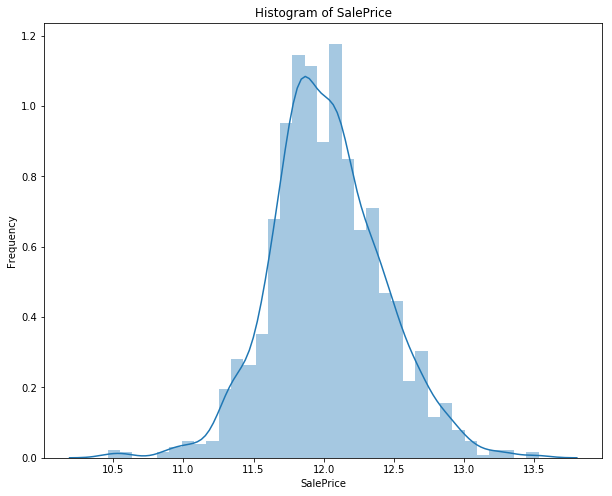

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Histogram of SalePrice')
ax.set_ylabel('Frequency')
ax = sns.distplot(data['SalePrice'])
plt.show()

In [50]:
print('Skewness:', data['SalePrice'].skew())
print('Kurtosis:', data['SalePrice'].kurtosis())

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


Some notable characteristics from looking at this information:

- The mean `SalePrice` is around \\$180k, which is lower than today's average of about \\$220k (as of 1/6/2020) in Ames, Iowa, where this dataset is taken from. As such, this dataset is not up-to-date.
- The minimum housing price is about \\$3400, and not a negative number or 0, showing that the housing prices were recorded properly.
- The maximum housing price is about \\$755k, which seems to be an outlier given the mean. 
- **Skewness measures lack of symmetry of a graph**, where symmetry is defined as a graph looking similar on the left side of the center point as on the right side. 0 represents a perfectly symmetrical graph i.e. a normal distribution. Values farther from 0 show more skewed distributions. In this case, we see that the data is skewed to the right given the positive value for the skewness. [Cited from here.](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm)
- **Kurtosis measures the tailedness of the distribution**, and whether or not it is 'heavily-tailed' or 'light-tailed' in relation to the normal distribution. The standard normal distribution has a kurtosis of 0, and positive values indicate a distribution with a heavier tale, as in this case. [Cited from here.](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm)
- Looking at the graph, one can see that this is a **unimodal distribution skewed heavily towards increasing sales prices**. Let us test and see whether or not our intuitions are correct and check the normality of this distribution.


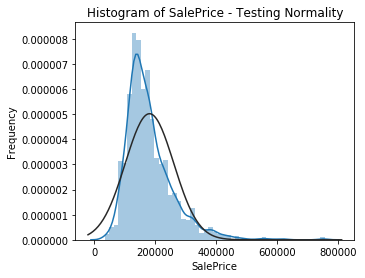

In [59]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Histogram of SalePrice - Testing Normality')
ax.set_ylabel('Frequency')
ax = sns.distplot(data['SalePrice'], fit = norm)
plt.show()

Above, the blue line is the gaussian kernel density estimate of the histogram, which is a way of predicting the probability density function of `SalePrice`. The black line is the maximum likelihood gaussian distribution fit of the data. These two lines should be similar with each other if the data were normal. This implies that `SalePrice` is not normal.

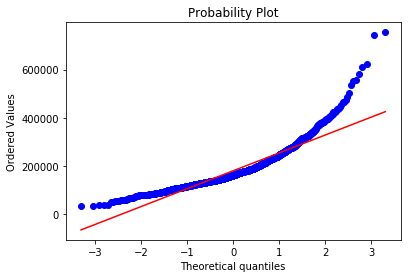

In [60]:
res = stats.probplot(data['SalePrice'], plot=plt)

This is a [probability plot](https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm) of the data (blue dots) and of the normal distribution (red line). A probability plot is a graphical means of verifying if a given distribution is similar to another theoretical distribution (such as the normal distribution). The points are plotted in such a way that they should form a straight, diagonal line. Deviations from a straight line imply that it is not like the theoretical distribution it is being compared with. 

These two lines should be similar if the data were normal, thus implying again that `SalePrice` is not normal. 

To deal with non-normality, we can simply transform the data. There are many methods for transforming the data, including applying a [Johnson SU transformation](https://en.wikipedia.org/wiki/Johnson%27s_SU-distribution) or by [applying the log function to the data](http://onlinestatbook.com/2/transformations/log.html). Given the positive skewness of this problem, I will use log transformation for `SalePrice`.

In [61]:
#data['SalePrice'] = np.log(data['SalePrice'])

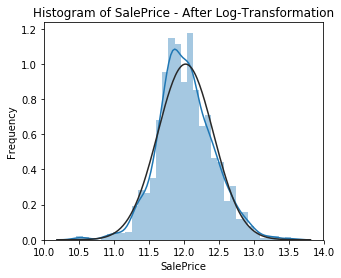

In [64]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Histogram of SalePrice - After Log-Transformation')
ax.set_ylabel('Frequency')
ax = sns.distplot(data['SalePrice'], fit = norm)
plt.show()

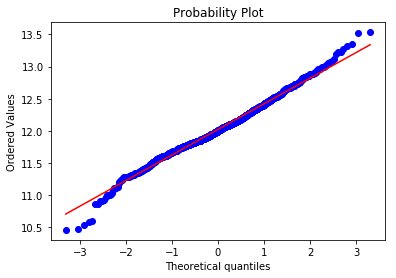

In [65]:
res = stats.probplot(data['SalePrice'], plot=plt)

After the transformation, we see that the data now closely resembles a normal distribution, and as such, statistical tests can be applied to `SalePrice`. Another problem that ensuring `SalePrice` is normal solves is the issue of [heteroscedasticity](https://www.statisticssolutions.com/homoscedasticity/), which describes where an error term (the 'noise' involved in the problem), is different across all values of an independent variable. This is an issue given that it would be difficult to create a regression model when heteroscedasticity is present, as there would be great variety in an independent variable i.e. a cone shape would form from plotting this independent variable. As such, we 'stabilize' this variety by transforming the dependent variable.

### Conclusion

`SalePrice` was originally a unimodal, skewed, non-normal distribution taking on quantitative values. To transform the data, we took the log of each of the values of `SalePrice`, and were able to create a new distribution extremely close to normal. This method can be done to other quantitative variables, as well. 

## Independent Variables: The Other Guys

I will 